In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
import matplotlib.gridspec as gridspec
sns.set_style('whitegrid')

from scipy.stats import mannwhitneyu
from scipy.stats import spearmanr

import warnings
warnings.filterwarnings('ignore')

In [2]:
from statsmodels.nonparametric.smoothers_lowess import lowess

In [3]:
import textwrap

In [4]:
colormap = 'RdBu_r'

## Figure 1

# A

In [5]:
host_pw = pd.read_csv('../results/microarray_and_rnaseq_progeny_z_bioconductor.csv', sep=',', header=0, index_col=0)
host_tf = pd.read_csv('../results/microarray_and_rnaseq_dorothea_ABC.csv', sep=',', header=0, index_col=0)

In [6]:
samples = ['GSE147507.S5_A549_SARS.CoV.2','GSE147507.S7_Calu3_SARS.CoV.2','GSE148729_Calu3_SARS.CoV.2_24H']
host_pw = host_pw[samples]
host_pw.columns = ['GSE147507 A549', 'GSE147507 Calu-3', 'GSE148729 Calu-3']

In [7]:
custom_palette = sns.color_palette("RdBu_r", 120)[:48] + sns.color_palette("RdBu_r", 120)[72:]

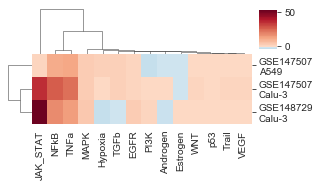

In [8]:
g = sns.clustermap(host_pw.T,cmap=custom_palette, figsize=(5,2.7), dendrogram_ratio=(.1, .4), 
                   cbar_pos = [0.73, 0.73, 0.05, 0.2],
                   center = 0
                   #cbar_pos = [0.555,0.83,0.2,0.15],
                   #cbar_kws = {'orientation':'horizontal'}
                  )
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 10)
g.ax_heatmap.set_yticklabels((textwrap.fill(y.get_text(), 9) for y in g.ax_heatmap.get_ymajorticklabels()), 
                             fontsize = 10)

plt.savefig('../figures/draft/Fig1A.pdf', dpi=300)

# B

In [9]:
host_tf = host_tf.loc[samples]
host_tf.index = ['GSE147507 A549', 'GSE147507 Calu-3', 'GSE148729 Calu-3']

In [10]:
tfs_host = host_tf.columns[host_tf.abs().mean()>4]

In [11]:
host_tf[tfs_host].min().min()

-8.26524944676972

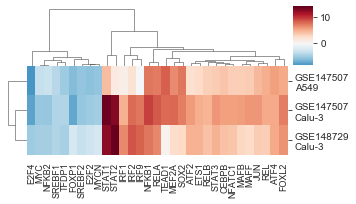

In [12]:
g = sns.clustermap(host_tf[tfs_host],cmap=colormap,xticklabels=True, figsize=(5.5,3), 
                  dendrogram_ratio=(.07, .4), cbar_pos = [0.75, 0.68, 0.05, 0.27], center = 0)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 9)
g.ax_heatmap.set_yticklabels((textwrap.fill(y.get_text(), 9) for y in g.ax_heatmap.get_ymajorticklabels()), 
                             fontsize = 10)
plt.savefig('../figures/draft/Fig1B.pdf', transparent=True)

### TODO: CARNIVAL plot

## Figure 2

In [13]:
chembl_drugs = pd.read_csv('../results/drugs/chembl_drugs.csv', sep=',', header=0, index_col=0)

# A

In [14]:
drug_pw = pd.read_csv('../results/drug_signatures/signatures_bing_gene_progeny_z.csv', sep=',', header=0, 
                     index_col=0)
drug_tf = pd.read_csv('../results/drug_signatures/signatures_bing_gene_dorothea.csv', sep=',', header=0,
                     index_col=0)

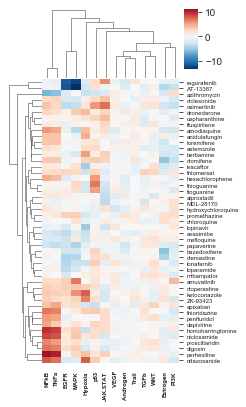

In [15]:
g = sns.clustermap(drug_pw[chembl_drugs['0'].values].T, cmap=colormap, yticklabels=True, figsize=(4, 6),
                  cbar_pos=[0.65, 0.83, 0.05, 0.14], center = 0
                  )
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 6, fontweight = 'bold')
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 6)
plt.savefig('../figures/draft/Fig2A.pdf')
plt.show()

# B

In [16]:
from scipy.cluster.hierarchy import linkage
from sklearn.cluster import AgglomerativeClustering

In [17]:
clustering = linkage(drug_tf.loc[chembl_drugs['0'].values],method='average')

In [18]:
pal = sns.color_palette(colormap, 7)
cluster_colors = pal.as_hex()

In [19]:
cluster_dict = {}
i=0
for color in cluster_colors:
    cluster_dict[i] = color
    i=i+1

In [20]:
model = AgglomerativeClustering(linkage='average', n_clusters=7)
model.fit(drug_tf.loc[chembl_drugs['0'].values])
model.fit_predict(drug_tf.loc[chembl_drugs['0'].values])
clusters = pd.Series(model.fit_predict(drug_tf.loc[chembl_drugs['0'].values]),index=chembl_drugs['0'].values)
#for i in range(len(set(clusters.values))):
#    clusters[clusters==i] = cluster_colors[i]
#clusters.to_csv('../results/drug_clusters.csv', sep=',')

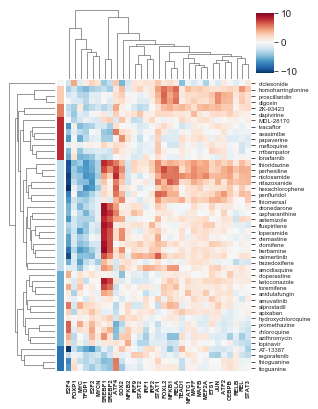

In [21]:
g = sns.clustermap(drug_tf.loc[chembl_drugs['0'].values, tfs_host], cmap=colormap, xticklabels=True,
                   yticklabels=True, row_colors=clusters.map(cluster_dict), figsize=(5,6), row_linkage=clustering,
                  cbar_pos=[0.72, 0.82, 0.05, 0.14], vmax=10, center = 0
                  )
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 6, fontweight = 'bold')
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 6)

plt.savefig('../figures/draft/Fig2B.pdf')
plt.show()

# C

In [22]:
textpos_dict = {}
for c in np.unique(clusters):
    tfs = list(set(drug_tf.columns) & set(host_tf.columns))
    means = pd.DataFrame(columns=['tf', 'x_mean', 'y_mean'])
    drugs = clusters.index[clusters==c]
    for tf in tfs:
        ser = pd.Series([tf,drug_tf.loc[drugs,tf].mean(), host_tf[tf].mean()],index=means.columns)
        means = means.append(ser,ignore_index=True)
        #plt.text(drug_tf.loc[drugs,tf].mean(), host_tf[tf].mean(),tf, color=c)
    means = means.set_index('tf')
    x_means = means['x_mean']
    y_means = means['y_mean']
    means = means[((means['x_mean'] >  x_means.max()*0.6) | (means['x_mean'] <  x_means.min()*0.6)) & 
                  ((means['y_mean'] >  y_means.max()*0.6) | (means['y_mean'] <  y_means.min()*0.6)) |
                 ((means['x_mean'] >  x_means.max()*0.8) | (means['x_mean'] <  x_means.min()*0.8) | 
                 (means['y_mean'] >  y_means.max()*0.8) | (means['y_mean'] <  y_means.min()*0.8))]
    textpos_dict[c] = means

In [23]:
def plot_txt(c):
    
    
    textpos_dict[c].sort_values('y_mean')
    for tf in tfs:
        if tf in textpos_dict[c].index:
            if c == 1: 
                va = 'bottom' if tf in ['SREBF1', 'STAT1'] else 'top'
                ha = 'right' if tf in ['E2F2', 'E2F4'] else 'left'
            elif c == 3: 
                ha = 'right' if tf in ['FOXO3', 'FOXP1', 'SOX2'] else 'left'
                va = 'bottom' if tf in ['TCF12'] else 'top'
            elif c == 2: 
                ha = 'right' if tf in ['STAT2', 'MYC'] else 'left'
                va = 'bottom' if tf in ['SREBF1', 'STAT2'] else 'top'
                ha = 'center' if tf in ['SREBF2', 'SREBF1', 'STAT1'] else ha
            elif c == 6:
                ha = 'center' if tf in [ 'MYC', 'ZNF263', 'PRDM14', 'POU2F1','STAT1'] else 'left'
                va = 'bottom' if tf in ['PRDM14', 'MYC', 'STAT2', 'ZNF263'] else 'top' #, 'POU2F1'
                va = 'center' if tf == 'POU2F1' else va
            elif c == 5:
                ha = 'right' if tf in ['KLF4', 'KLF9'] else 'left'
                va = 'bottom' if tf in ['KLF4', 'TFAP2A', 'MAX'] else 'top'     
            elif c == 0:
                ha = 'right' if tf in ['SSRP1', 'KMT2A', 'STAT1', 'ARID2', 'ATF4'] else 'left'
                va = 'bottom' if tf in ['KMT2A', 'ATF4', 'E2F4', 'STAT1'] else 'top'   
            elif c == 4:
                ha = 'right' if tf in ['FOXL2', 'RELA', 'NFKB1', 'ARID2', 'STAT2'] else 'left'
                va = 'bottom' if tf in ['MYC', 'STAT1', 'NFKB1', 'STAT2', 'MAZ'] else 'top'   
            else:
                va = 'top'
                ha = 'left'
            if tf == 'SREBF1' or tf == 'SREBF2':
                color = '#900600'
            else:
                color = 'black'
            plt.text(textpos_dict[c].loc[tf, 'x_mean'], textpos_dict[c].loc[tf, 'y_mean'],tf, 
                     va = va, ha=ha, fontdict={'family': 'sans-serif','weight': 'bold',
                                               'color': color,'size': 8})
            #i=i+1

In [24]:
def cluster_subplots(c):
    drugs = clusters.index[clusters==c]
    ax = plt.plot(drug_tf.loc[drugs,tfs].mean(), host_tf[tfs].mean(),color=cluster_dict[c], marker='.', linestyle='',markersize=2)
    plot_txt(c)

In [25]:
def print_cluster_spearman(c):
    print(c, cluster_dict[c], end=' ')
    drugs = clusters.index[clusters==c]
    print(spearmanr(drug_tf.loc[drugs,tfs].mean(), host_tf[tfs].mean()))

4 #fbccb4 SpearmanrResult(correlation=0.6423788717326555, pvalue=8.550102394997167e-35)
0 #2a71b2 SpearmanrResult(correlation=0.14763213098693254, pvalue=0.012284426712145342)
6 #ba2832 SpearmanrResult(correlation=0.1840205485623494, pvalue=0.0017440270434621633)
2 #c2ddec SpearmanrResult(correlation=0.5802930759009984, pvalue=3.1440921855564533e-27)
1 #6bacd1 SpearmanrResult(correlation=0.04138469289467974, pvalue=0.4849641577602919)


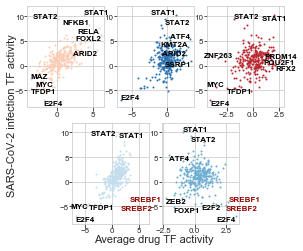

In [26]:
fig = plt.figure(figsize=(4.6,4))

tfs = list(set(drug_tf.columns) & set(host_tf.columns))

grid = plt.GridSpec(2, 1, wspace=0.4, hspace=0.15, figure=fig)

gs0 = gridspec.GridSpecFromSubplotSpec(1, 6, subplot_spec=grid[0], wspace=0.4, hspace=0.15)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 6, subplot_spec=grid[1],  wspace=0.4, hspace=0.15)

ax0 = fig.add_subplot(grid[:,:])
ax0.grid(False)
ax0.set_frame_on(False)
ax0.set_xticks([])
ax0.set_yticks([])

ax1 = fig.add_subplot(gs0[0, :2])
c= 4
cluster_subplots(c)
print_cluster_spearman(c)

ax2 = fig.add_subplot(gs0[0, 2:4])
c= 0
ax2 = cluster_subplots(c)
ax2 = print_cluster_spearman(c)

ax3 = fig.add_subplot(gs0[0, 4:])
c= 6
ax3 = cluster_subplots(c)
ax3 = print_cluster_spearman(c)


ax4 = fig.add_subplot(gs1[0, 1:3])
c= 2
ax4 = cluster_subplots(c)
ax4 = print_cluster_spearman(c)

ax5 = fig.add_subplot(gs1[0, 3:5])
c= 1
ax5 = cluster_subplots(c)
ax5 = print_cluster_spearman(c)

ax0.set_xlabel('Average drug TF activity ', labelpad=10, fontsize =11)
ax0.set_ylabel('SARS-CoV-2 infection TF activity', labelpad = 10, fontsize = 11)


for ax in fig.get_axes():
    ax.tick_params(labelsize=8, bottom=True, left=True, pad=0)
    ax.set_ylim([-8.5,12])



plt.savefig(f'../figures/draft/Fig2C.pdf', dpi = 300, transparent=True)
plt.show()

# E

In [27]:
similarity = pd.read_csv('../results/drug_signatures/similarities_lm_genes.csv', sep=',', header=0, index_col=0)

MannwhitneyuResult(statistic=574013.5, pvalue=5.018925204438976e-18)


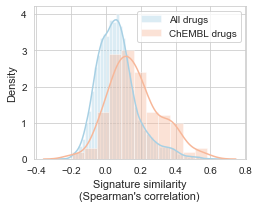

In [28]:
plt.figure(figsize=(3.7,3), tight_layout = True)
sns.set_palette(colormap, 2)
# all drugs
sns.distplot(similarity.loc[samples].values.reshape((1,-1))[0])
# chembl drugs
sns.distplot(similarity.loc[samples,chembl_drugs['0'].values].values.reshape((1,-1))[0])

plt.legend(['All drugs','ChEMBL drugs'])
print(mannwhitneyu(similarity.loc[samples].values.reshape((1,-1))[0],
            similarity.loc[samples,chembl_drugs['0'].values].values.reshape((1,-1))[0]))
plt.xlabel("Signature similarity\n(Spearman's correlation)", size=11)
plt.ylabel('Density', size=11)
plt.savefig('../figures/draft/Fig2E.pdf', transparent = True)

## Figure 3

In [29]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# A

0.7470505411175734
0.7410549952146066
0.641017264227343


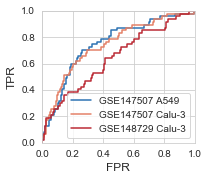

In [30]:
plt.figure(figsize=(3,2.6))
sns.set_palette(sns.color_palette(['#2a71b2', '#e48066', '#ba2832']))

for sample in samples:
    y_pr = similarity.loc[sample]
    y_tr = pd.Series(0, index=similarity.columns)
    y_tr[chembl_drugs['0'].values] = 1
    fpr, tpr, dummy = roc_curve(y_true=y_tr, y_score=y_pr)
    plt.plot(fpr, tpr, label=sample)
    print(roc_auc_score(y_score=y_pr, y_true=y_tr))
    plt.xlabel('FPR', fontsize=12)
    plt.ylabel('TPR',  fontsize=12)
    #plt.plot([0, 1], [0, 1], '--', color='grey')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    
    plt.legend(['GSE147507 A549', 'GSE147507 Calu-3', 'GSE148729 Calu-3'], fontsize = 10)
    plt.tight_layout()
    plt.savefig('../figures/draft/Fig3A.pdf')

# B

In [31]:
host_pw = pd.read_csv('../results/microarray_and_rnaseq_progeny_z_bioconductor.csv', sep=',', header=0, index_col=0)

In [32]:
other_samples = ['GSE33267_Calu3_SARS.CoV', 'GSE148729_Calu3_SARS.CoV_24H',
                 'GSE45042_Calu3_MERS', 'GSE56677_Calu3_MERS', 
                'GSE147507.S3_A549_RSV', 'GSE147507.S8_A549_RSV', 
                'GSE28166_Calu3_H5N1', 'GSE37571_Calu3_Influenza', 
                'GSE147507.S8_A549_HPIV']

In [33]:
other_pw = host_pw[other_samples]

In [34]:
other_pw.columns = ['GSE33267 Calu-3 SARS-CoV', 'GSE148729 Calu-3 SARS-CoV',
                   'GSE45042 Calu-3 MERS', 'GSE56677 Calu-3 MERS', 
                   'GSE147507 S3 A549 RSV', 'GSE147507 S8 A549 RSV', 
                   'GSE28166 Calu-3 H1N1', 'GSE37571 Calu-3 Infuenza', 
                   'GSE147507 S8 A549 HPIV']

GSE33267_Calu3_SARS.CoV 	 0.7029144886991092
GSE148729_Calu3_SARS.CoV_24H 	 0.6782743134800854
GSE45042_Calu3_MERS 	 0.5148761319296178
GSE56677_Calu3_MERS 	 0.5994533608186704
GSE147507.S3_A549_RSV 	 0.6403684753000074
GSE147507.S8_A549_RSV 	 0.7072489508945006
GSE28166_Calu3_H5N1 	 0.4667047044099242
GSE37571_Calu3_Influenza 	 0.5595965545166752
GSE147507.S8_A549_HPIV 	 0.5946265552528898


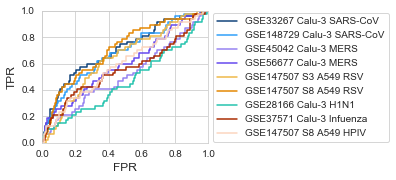

In [35]:
plt.figure(figsize=(5.6,2.6))
colors = ['#0e4179', '#2D9EF9', '#9581F1', '#6447EE', '#EEB847', '#E48600', '#23C3AD', '#A92A00', '#fcd5bf']
sns.set_palette(sns.color_palette(colors))
for sample in other_samples:
    y_pr = similarity.loc[sample]
    y_tr = pd.Series(0, index=similarity.columns)
    y_tr[chembl_drugs['0'].values] = 1
    fpr, tpr, dummy = roc_curve(y_true=y_tr, y_score=y_pr)
    plt.plot(fpr, tpr, label=sample)
    print(sample, '\t',roc_auc_score(y_score=y_pr, y_true=y_tr))
plt.xlabel('FPR', fontsize=12)
plt.ylabel('TPR',  fontsize=12)
#plt.plot([0, 1], [0, 1], '--', color='red')
plt.xlim([0, 1])
plt.ylim([0, 1])
    
plt.legend(other_pw.columns, fontsize = 10, bbox_to_anchor=(1, 1.02), loc='upper left')
plt.tight_layout()
plt.savefig('../figures/draft/Fig3B.pdf', transparent=True, dpi=300)

# C

### Comparison of ROC AUC values of models (similarity-based, random forest-based)

In [36]:
rocaucs = pd.read_csv('../results/random_forest_classification/rocaucs_n_300.csv', index_col=0)

In [37]:
rocaucs = rocaucs[['GSE147507.S5_A549_SARS.CoV.2','GSE147507.S7_Calu3_SARS.CoV.2', 
            'GSE148729_Calu3_SARS.CoV.2_24H', 'rf_based']]

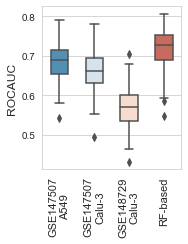

In [38]:
plt.figure(figsize=(2.6,3.5))

boxplot = sns.boxplot(data = rocaucs, palette=colormap, width=0.5)
boxplot.set_xticklabels(['GSE147507\nA549', 'GSE147507\nCalu-3', 'GSE148729\nCalu-3', 'RF-based'], 
                        rotation=90, fontsize = 11)
plt.tight_layout()
plt.ylabel('ROCAUC', fontsize=12)
plt.savefig('../figures/draft/Fig3C.pdf')
plt.show()

# D

### Feature importances

In [39]:
feature_imp = pd.read_csv('../results/random_forest_classification/feature_importances_n_300.csv', index_col = 0)

In [40]:
feature_imp_head = feature_imp.head(30)
fitb = pd.concat([feature_imp.head(10), feature_imp.tail(10)])
feature_imp_tail = feature_imp.tail(20)

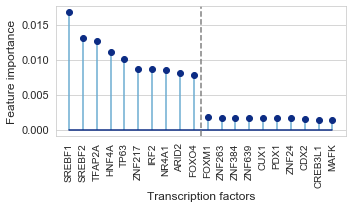

In [41]:
fig, ax = plt.subplots(figsize=(5, 3), tight_layout=True)

data = fitb
dark = '#0c2c84'
light = '#6bacd1'
markerline, stemlines, baseline = plt.stem(data['0'],use_line_collection = True) 

plt.setp(baseline, visible = True, color=dark )
plt.setp(stemlines, color=light)
plt.setp(markerline, color=dark)

plt.xticks(range(len(data)), data.index, rotation=90, fontsize = 10)
plt.yticks(fontsize = 11)
#plt.title('Feature importance', fontsize = 16)
plt.xlabel('Transcription factors', fontsize = 12)
plt.ylabel('Feature importance', fontsize = 12)

plt.axvline(x=9.5, color='gray', linestyle='--')
    
ax.grid(False, axis = 'x')

plt.savefig('../figures/draft/Fig3D.pdf')
plt.show()

## Figure 4

In [42]:
drug_tf_activities = pd.read_csv('../results/drug_signatures/signatures_bing_gene_dorothea.csv', sep=',', header=0,
                     index_col=0)

# B

##### middle panel

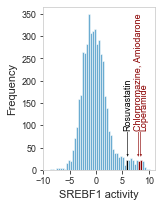

In [43]:
data = drug_tf_activities['SREBF1']
fig, ax = plt.subplots(figsize = (2,3))
N, bins, patches = plt.hist(drug_tf_activities['SREBF1'], edgecolor='white', linewidth=0.5, bins = 50, color = "#6bacd1")
loper = drug_tf_activities.loc['loperamide', 'SREBF1']
amio = drug_tf_activities.loc['amiodarone', 'SREBF1']
cp = drug_tf_activities.loc['chlorpromazine', 'SREBF1']
rosu = drug_tf_activities.loc['rosuvastatin', 'SREBF1']

for drug in [loper, amio, cp]:
    for i in range(len(bins)):
        if bins[i] > drug:
            patches[i-1].set_facecolor('darkred')
            break       
for drug in [rosu]:
    for i in range(len(bins)):
        if bins[i] > drug:
            patches[i-1].set_facecolor('black')
            break       

            
plt.arrow(rosu, 85, 0, -50, head_width=0.3, head_length=5, color='k', linewidth = 0.3)
plt.arrow(cp, 85, 0, -50, head_width=0.3, head_length=5, color='darkred', linewidth = 0.3)
plt.arrow(loper+0.1, 85, 0, -50, head_width=0.3, head_length=5, color='darkred', linewidth = 0.3)

plt.text(rosu, 92, 'Rosuvastatin', color='k', rotation = 90, ha = 'center', fontsize = 9)
plt.text(cp, 92, 'Chlorpromazine, Amiodarone', color='darkred', rotation = 90, ha = 'center', fontsize = 9)
plt.text(loper-0.1, 92,'Loperamide', color='darkred', rotation = 90, ha = 'left', fontsize = 9)

plt.xticks(fontsize = 9)
plt.xticks(np.arange(-10, 12, 5))
plt.yticks(fontsize = 9)
plt.tick_params(bottom = True, left = True)

plt.xlabel('SREBF1 activity', fontsize=11)
plt.ylabel('Frequency',  fontsize=11)
ax.grid(False)

plt.savefig('../figures/draft/Fig4Bmiddle.pdf', dpi= 300, bbox_inches = 'tight')

##### right panel

In [44]:
drug_pred_prob = pd.read_csv('../results/random_forest_classification/drug_predictive_probabilities_n_300.csv', index_col=0)

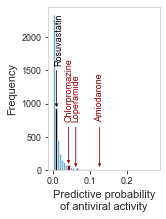

In [45]:
data = drug_pred_prob['Random Forest Predictive Probabilities']
fig, ax = plt.subplots(figsize = (2,3))
N, bins, patches = plt.hist(data, edgecolor='white', linewidth=0.5, bins = 50, color = "#6bacd1")
loper = data['loperamide']
amio = data.loc['amiodarone']
cp = data.loc['chlorpromazine']
rosu = data.loc['rosuvastatin']

for drug in [loper, amio, cp]:
    for i in range(len(bins)):
        if bins[i] > drug:
            patches[i-1].set_facecolor('darkred')
            break       
for drug in [rosu]:
    for i in range(len(bins)):
        if bins[i] > drug:
            patches[i-1].set_facecolor('black')
            break       
fntsz = 9
            
plt.arrow(rosu+0.001, 1500, 0, -500, head_width=0.008, head_length=50, color='k', linewidth = 0.3)
plt.arrow(cp+0.001, 650, 0, -500, head_width=0.008, head_length=50, color='darkred', linewidth = 0.3)
plt.arrow(amio, 650, 0, -550, head_width=0.008, head_length=50, color='darkred', linewidth = 0.3)
plt.arrow(loper, 650, 0, -550, head_width=0.008, head_length=50, color='darkred', linewidth = 0.3)

plt.text(rosu+0.006, 1600, 'Rosuvastatin', color='k', rotation = 90, ha = 'center', fontsize = fntsz)
plt.text(cp+0.002, 750, 'Chlorpromazine', color='darkred', rotation = 90, ha = 'center', fontsize =fntsz)
plt.text(amio, 750, 'Amiodarone', color='darkred', rotation = 90, ha = 'center', fontsize =fntsz)
plt.text(loper, 750,'Loperamide', color='darkred', rotation = 90, ha = 'center', fontsize = fntsz)

plt.xticks(fontsize = 9)
plt.xticks(np.arange(0, 0.25, 0.1), fontsize = 9)
plt.yticks(fontsize = 9)
plt.tick_params(bottom = True, left = True)

plt.xlabel('Predictive probability\nof antiviral activity', fontsize=11)
plt.ylabel('Frequency',  fontsize=11)
ax.grid(False)
plt.savefig('../figures/draft/Fig4Bright.pdf', dpi= 300, bbox_inches = 'tight')

#### Supplementary

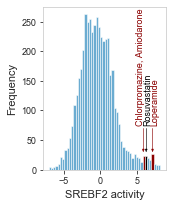

In [46]:
fig, ax = plt.subplots(figsize = (2.2,3))
N, bins, patches = plt.hist(drug_tf_activities['SREBF2'], edgecolor='white', linewidth=0.5, bins = 50, color = "#6bacd1")
loper = drug_tf_activities.loc['loperamide', 'SREBF2']
amio = drug_tf_activities.loc['amiodarone', 'SREBF2']
cp = drug_tf_activities.loc['chlorpromazine', 'SREBF2']
rosu = drug_tf_activities.loc['rosuvastatin', 'SREBF2']

for drug in [loper, amio, cp]:
    for i in range(len(bins)):
        if bins[i] > drug:
            patches[i-1].set_facecolor('darkred')
            break       
for drug in [rosu]:
    for i in range(len(bins)):
        if bins[i] > drug:
            patches[i-1].set_facecolor('black')
            break
            
plt.arrow(rosu+0.15, 70, 0, -35, head_width=0.3, head_length=5, color='k', linewidth = 0.3)
plt.arrow(cp-0.1, 70, 0, -35, head_width=0.3, head_length=5, color='darkred', linewidth = 0.3)
plt.arrow(loper+0.1, 70, 0, -35, head_width=0.3, head_length=5, color='darkred', linewidth = 0.3)

plt.text(rosu+0.3, 78, 'Rosuvastatin', color='k', rotation = 90, ha = 'center', fontsize = 9)
plt.text(cp+0.1, 78, 'Chlorpromazine, Amiodarone', color='darkred', rotation = 90, ha = 'right', fontsize = 9)
plt.text(loper+0.4, 78,'Loperamide', color='darkred', rotation = 90, ha = 'center', fontsize = 9)

plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9)
plt.tick_params(bottom = True, left = True)

plt.xlabel('SREBF2 activity', fontsize=11)
plt.ylabel('Frequency',  fontsize=11) 
ax.grid(False)

plt.savefig('../figures/draft/Fig4BS2.pdf', dpi= 300, bbox_inches = 'tight')

# D

In [47]:
drugmap = {'dmso':'DMSO', 'mbcd': 'MBCD', 'amio': 'Amiodarone', 
           'loper':'Loperamide', 'cp':'Chlorpromazine', 'rosu':'Rosuvastatin'}

In [48]:
colormap = {'mbcd': '#6bacd1', 'dmso':'#fc8403', 'cp':'#A92A00', 'amio': '#6447EE', 
           'loper':'#0e4179', 'rosu' : '#6d6d6d'}# 'rosu':'#EEB847'}

In [49]:
def plot_results_timemin(data, min_y = -0.8, max_time = 270):
    tmp = data.copy()
    tmp.Drug = tmp.Drug.map(drugmap)
    fig, ax = plt.subplots(figsize = (4,5))
    plot = sns.lineplot(data=tmp, x="Time_min", y="logRatio", hue = 'Drug', palette = colormap.values())
    plt.axvline(0, color = 'r')
    plt.xticks(np.arange(-30, 21*14, 30))
    plot.set(xlim=(-30, max_time))
    plot.set(ylim=(min_y, -0.2))
    plot.set(xlabel='Time (min)')
    plt.savefig('../figures/draft/Fig4D.pdf', dpi= 300, bbox_inches = 'tight')
    plt.show()

In [50]:
exp_all = pd.read_csv('../results/cholesterol_sensor_experiments/exp_234_results.csv', index_col =0)

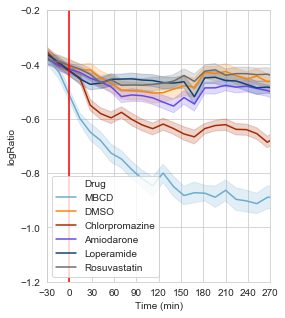

In [51]:
plot_results_timemin(exp_all, min_y = -1.2)

## Figure 5

# B

In [52]:
experiments = ['20210601', '20210629', '20210720', '20210810']

In [53]:
experiments_table = pd.DataFrame(columns = ['Drug', 'PCR', 'Cholesterol', 'Experiment'])
data = {}
for exp in experiments:
    print(exp)
    
    data[exp] = pd.read_excel('../data/ddPCR_koleszterinvsSARSvsDrug.xlsx', sheet_name = exp)
    # delete co-administration data
    idx = data[exp].where(data[exp]=='Co-administration').dropna(how = 'all').index

    if len(idx) > 0:
        data[exp] = data[exp][:idx[0]]
    
    # drop all NaN values and fill drug values
    data[exp] = data[exp].dropna(how = 'all').fillna(method = 'ffill', axis = 0).dropna(axis = 1, how = 'all')
    data[exp].columns = data[exp].iloc[0]
    data[exp] = data[exp].iloc[1:, :6]

    data[exp].columns = [ '0um_chol', '0um_chol_PCR', '80um_chol',
                 '80um_chol_PCR', '10um_chol', '10um_chol_PCR']
    
    # append data to experiments_table
    for cc in [0, 80, 10]:
        tmp = data[exp][[str(cc)+'um_chol', str(cc)+'um_chol_PCR']]
        tmp['Cholesterol'] = str(cc)+'um'
        tmp['Experiment'] = exp
        tmp.columns = experiments_table.columns
        
        experiments_table = experiments_table.append(tmp, ignore_index = True)
    experiments_table = experiments_table.drop_duplicates()
    

20210601
20210629
20210720
20210810


In [54]:
experiments_table = experiments_table.replace('Pozitív ctrl', 'Control')
experiments_table = experiments_table.replace('DMSO ', 'DMSO')
experiments_table = experiments_table.replace('Chlorpromazine ', 'Chlorpromazine')
experiments_table = experiments_table.replace('Amiodarone (DMSO)', 'Amiodarone')

experiments_table.PCR = experiments_table.PCR.apply(lambda x: float(str(x).replace(',', '.')))

In [55]:
toplot = experiments_table[experiments_table.Drug.isin(['Control', 'Chlorpromazine',
                                                        'Amiodarone', 'Loperamide']) & 
                          experiments_table.Cholesterol.isin(['0um', '80um'])]


In [56]:
toplot = toplot.replace('0um', 'No cholesterol')
toplot = toplot.replace('80um', '80 \u03BCM cholesterol')

In [57]:
toplot.PCR = np.log2(toplot.PCR)
toplot["Drug"] = pd.Categorical(toplot["Drug"],
                                categories = ["Control", "Amiodarone", "Chlorpromazine", "Loperamide"])

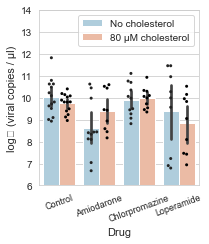

In [58]:
fig, ax = plt.subplots(figsize = (3,3.5))
g = sns.barplot(x = 'Drug', y = 'PCR', hue = 'Cholesterol', data=toplot, palette = 'RdBu_r')
g = sns.swarmplot(x = 'Drug', y = 'PCR', hue = 'Cholesterol', 
                  data=toplot, dodge=True, color = 'k', size = 3)

handles, labels = g.get_legend_handles_labels()
g.legend(handles[2:], labels[2:])

plt.ylim((6,14))
plt.xticks(rotation = 20, ha="center", fontsize = 9)
plt.xlabel('Drug', fontsize = 11)
plt.ylabel('log\u2082 (viral copies / \u03BCl)', fontsize = 11)
plt.tight_layout()
plt.savefig('../figures/draft/Fig5B.pdf')
plt.show()